In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data_from_npy_files(data_dir):
    X, y = [], []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(data_dir, file_name)
            data = np.load(file_path, allow_pickle=True).item()  # Load the .npy file
            
            frames = data['frames']
            label = data['label']
            
            # Append the frames and label to the lists
            X.append(frames)
            y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Load training and testing data
train_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/train'
test_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/test'

X_train, y_train = load_data_from_npy_files(train_data_dir)
X_test, y_test = load_data_from_npy_files(test_data_dir)

# Split the training data into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (1431, 32, 64, 64, 3), Labels shape: (1431,)
Validation data shape: (358, 32, 64, 64, 3), Labels shape: (358,)
Testing data shape: (306, 32, 64, 64, 3), Labels shape: (306,)


In [2]:
# Count occurrences of values 1 and 0 in y_train, y_val, and y_test

train_zeros = np.count_nonzero(y_train == 0)

train_ones = np.count_nonzero(y_train == 1)

val_zeros = np.count_nonzero(y_val == 0)

val_ones = np.count_nonzero(y_val == 1)

test_zeros = np.count_nonzero(y_test == 0)

test_ones = np.count_nonzero(y_test == 1)



# Print counts

print(f"Training data - 0s: {train_zeros}, 1s: {train_ones}")

print(f"Validation data - 0s: {val_zeros}, 1s: {val_ones}")

print(f"Testing data - 0s: {test_zeros}, 1s: {test_ones}")

Training data - 0s: 633, 1s: 798
Validation data - 0s: 167, 1s: 191
Testing data - 0s: 150, 1s: 156


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, MaxPooling3D, GlobalAveragePooling3D, Add, Dense
from tensorflow.keras.models import Model

# 3D Convolutional Block
def conv3d_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same'):
    """
    A convolutional block with Conv3D, BatchNormalization, and ReLU activation.
    
    Args:
        x (tensor): Input tensor to the block.
        filters (int): Number of filters for the Conv3D layer.
        kernel_size (tuple): The kernel size for the Conv3D layer.
        strides (tuple): The strides for the Conv3D layer.
        padding (str): The padding method for Conv3D layer.
    
    Returns:
        tensor: The output tensor after applying Conv3D, BatchNorm, and ReLU.
    """
    x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Residual Block
def residual_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same'):
    """
    A residual block that adds the input to the output of the block.
    
    Args:
        x (tensor): Input tensor to the block.
        filters (int): Number of filters for the Conv3D layers.
        kernel_size (tuple): The kernel size for the Conv3D layers.
        strides (tuple): The strides for the Conv3D layers.
        padding (str): The padding method for Conv3D layers.
    
    Returns:
        tensor: The output tensor after adding the input to the output.
    """
    shortcut = x  # Save the input tensor for the residual connection
    
    # Apply 1x1x1 convolution to match the number of filters in the shortcut path
    if x.shape[-1] != filters:  # Only apply if the number of filters is different
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(shortcut)
    
    # First convolutional block
    x = conv3d_block(x, filters, kernel_size, strides, padding)
    
    # Second convolutional block
    x = conv3d_block(x, filters, kernel_size, strides, padding)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

# 3D ResNet Model for Feature Extraction
def build_3d_resnet_feature_extractor(input_shape=(32, 64, 64, 3)):
    """
    Build a 3D ResNet model for feature extraction.
    
    Args:
        input_shape (tuple): Shape of the input video segments (frames, height, width, channels).
        
    Returns:
        model (tf.keras.Model): The 3D ResNet feature extractor model.
    """
    inputs = Input(shape=input_shape)

    # Initial Conv3D Block
    x = conv3d_block(inputs, 64, kernel_size=(3, 3, 3), strides=(1, 1, 1))
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # Residual Blocks
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    # Global Average Pooling (to reduce spatial dimensions)
    x = GlobalAveragePooling3D()(x)
    
    # # Final dense layer for feature extraction (optional)
    # x = Dense(4096, activation='relu')(x)  # Output a 4096-dimensional feature vector

    # Define the model (this model only extracts features, no classification)
    model = Model(inputs=inputs, outputs=x, name="3D_ResNet_Feature_Extractor")
    
    return model

import numpy as np

def extract_features_3d_resnet(video_segments, resnet_model):
    """
    Extract feature vectors from a batch of video segments using the 3D ResNet model.
    
    Args:
        video_segments (np.array): A batch of video segments, each with shape (frames, height, width, channels).
        resnet_model (tf.keras.Model): The pre-trained 3D ResNet model used for feature extraction.
    
    Returns:
        np.array: An array of feature vectors extracted from the video segments.
    """
    # Preprocess video segments and extract features
    features = []
    for segment in video_segments:
        segment = np.expand_dims(segment, axis=0)  # Add batch dimension (1, frames, height, width, channels)
        feature_vector = resnet_model.predict(segment)  # Extract feature vector using the ResNet model
        features.append(feature_vector.flatten())  # Flatten the feature vector for easier handling
    return np.array(features)


In [15]:
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



# Build the 3D ResNet feature extractor model

resnet_feature_extractor = build_3d_resnet_feature_extractor(input_shape=(32, 64, 64, 3))

resnet_feature_extractor.summary()



# Extract features using 3D ResNet for training, validation, and test data

X_train_features_resnet = extract_features_3d_resnet(X_train, resnet_feature_extractor)

X_val_features_resnet = extract_features_3d_resnet(X_val, resnet_feature_extractor)

X_test_features_resnet = extract_features_3d_resnet(X_test, resnet_feature_extractor)


Model: "3D_ResNet_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_14 (Conv3D)  │ (None, 32, 64,    │      5,248 │ input_layer_3[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ conv3d_14[0][0]   │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ re_lu_7[0][0]     │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 32, 32,    │    221,312 │ max_pooling3d_5[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_16[0][0]   │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 32, 32,    │    442,496 │ re_lu_8[0][0]     │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_17[0][0]   │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 32, 32,    │      8,320 │ max_pooling3d_5[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ re_lu_9[0][0],    │
│                     │ 32, 128)          │            │ conv3d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 32, 32,    │    884,992 │ add_3[0][0]       │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv3d_19[0][0]   │
│ (BatchNormalizatio… │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 32, 32,    │  1,769,728 │ re_lu_10[0][0]  

 Total params: 14,121,984 (53.87 MB)

 Trainable params: 14,118,272 (53.86 MB)

 Non-trainable params: 3,712 (14.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [22]:

X_train_features = X_train_features_resnet
X_val_features = X_val_features_resnet
X_test_features = X_test_features_resnet


In [23]:
import tensorflow as tf

def ranking_loss(y_true, y_pred, margin=1.0):
    # Contrastive loss
    # y_true should be 0 for negative pairs and 1 for positive pairs
    # margin is the minimum distance between the negative pairs
    # Calculate squared Euclidean distance between the predicted and true values
    squared_diff = tf.square(y_true - y_pred)
    
    # If y_true is 1 (positive pair), minimize the distance (squared difference)
    # If y_true is 0 (negative pair), maximize the distance by enforcing a margin
    loss = y_true * squared_diff + (1 - y_true) * tf.maximum(0.0, margin - squared_diff)
    
    # Mean loss across the batch
    return tf.reduce_mean(loss)
def temporal_smoothness_loss(y_true, y_pred):
    # Calculate the absolute differences between consecutive frames
    temporal_diff = tf.abs(y_pred[1:] - y_pred[:-1])

    # Calculate the mean of the temporal differences
    loss = tf.reduce_mean(temporal_diff)

    return loss
    
    return smoothness_loss
def combined_loss(y_true, y_pred, margin=1.0, smoothness_weight=0.05, ranking_weight=1.0):

    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    # Temporal Smoothness Loss
    temporal_loss = temporal_smoothness_loss(y_true, y_pred)

    # Ranking Loss
    ranking_loss_val = ranking_loss(y_true, y_pred, margin)

    # Combine both losses with their respective weights
    total_loss = bce_loss + (ranking_weight * ranking_loss_val) - (smoothness_weight * temporal_loss)

    return total_loss

In [24]:
# Step 2: Define the fully connected classifier
fc_classifier = Sequential([
Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
Dense(256, activation='relu'),
Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with the combined loss
fc_classifier.compile(
    optimizer='adam', 
    loss=combined_loss, metrics=['accuracy'])

checkpoint = ModelCheckpoint("models/resnet/resnet_custom_loss_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Step 3: Train the classifier
feature_fc_history = fc_classifier.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_val_features, y_val), callbacks=[checkpoint, early_stop])

fc_classifier.save('models/resnet/resnet_custom_loss_model.h5')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5438 - loss: 1.0370
Epoch 1: val_loss improved from inf to 1.04014, saving model to models/resnet/resnet_custom_loss_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5441 - loss: 1.0364 - val_accuracy: 0.5335 - val_loss: 1.0401
Epoch 2/20
38/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5482 - loss: 1.0195 
Epoch 2: val_loss improved from 1.04014 to 1.03405, saving model to models/resnet/resnet_custom_loss_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5504 - loss: 1.0172 - val_accuracy: 0.5335 - val_loss: 1.0341
Epoch 3/20
37/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 1.0086 
Epoch 3: val_loss improved from 1.03405 to 1.03389, saving model to models/resnet/resnet_custom_loss_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5549 - loss: 1.0073 - val_accuracy: 0.5335 - val_loss: 1.0339
Epoch 4/20
38/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss

In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score

def quantify_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on training, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Print the results
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Collect loss and accuracy values
    loss_values = [train_loss, val_loss, test_loss]
    accuracy_values = [train_accuracy, val_accuracy, test_accuracy]

    # Plotting the results
    plt.figure(figsize=(14, 6))

    # Plot for loss values
    plt.subplot(1, 2, 1)
    plt.bar(['Train', 'Validation', 'Test'], loss_values, color=['skyblue', 'orange', 'green'])
    plt.title('Loss Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    plt.ylim([0, max(loss_values) + 0.1])

    # Annotate loss bars
    for i, v in enumerate(loss_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    # Plot for accuracy values
    plt.subplot(1, 2, 2)
    plt.bar(['Train', 'Validation', 'Test'], accuracy_values, color=['skyblue', 'orange', 'green'])
    plt.title('Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])

    # Annotate accuracy bars
    for i, v in enumerate(accuracy_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return loss_values, accuracy_values

def plot_history(model_history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

def calculate_metrics(y_true, y_pred_binary):
    """
    Calculate precision, recall, F1 score, and AUC.
    
    Parameters:
        y_true: Ground truth labels.
        y_pred_binary: Predicted labels (binary).
    
    Returns:
        tuple: Precision, Recall, F1-score, AUC
    """
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred_binary)
    return precision, recall, f1, auc

def mean_average_precision(y_true, y_pred_probs):
    """
    Calculate mean average precision (mAP).
    
    Parameters:
        y_true: Ground truth labels.
        y_pred_probs: Predicted probabilities for each sample.
    
    Returns:
        float: mAP score
    """
    return average_precision_score(y_true, y_pred_probs)

def calculate_iou(y_true, y_pred_binary):
    """
    Calculate Intersection over Union (IoU) for segmentation tasks.

    Parameters:
        y_true: Ground truth labels.
        y_pred_binary: Predicted labels (binary).

    Returns:
        float: IoU score
    """
    intersection = np.sum(np.logical_and(y_true == 1, y_pred_binary == 1))
    union = np.sum(np.logical_or(y_true == 1, y_pred_binary == 1))
    iou = intersection / float(union) if union != 0 else 0
    return iou

def evaluate_and_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold = 0.5):
    """
    Evaluates the model on the training, validation, and test datasets,
    and plots the loss and accuracy for each. Also reports additional metrics like 
    precision, recall, f1-score, AUC, mAP, confusion matrix, and IOU.

    Parameters:
        model: Trained model to be evaluated.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        X_test, y_test: Test data and labels.
    """
    # Evaluate the model on training, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Get the predicted probabilities for the test data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Convert probabilities to binary labels (using a threshold of 0.5)
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)

    # Calculate additional performance metrics
    train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_train, y_train_pred_binary)
    val_precision, val_recall, val_f1, val_auc = calculate_metrics(y_val, y_val_pred_binary)
    test_precision, test_recall, test_f1, test_auc = calculate_metrics(y_test, y_test_pred_binary)

    # Calculate mAP score for each dataset
    train_map = mean_average_precision(y_train, y_train_pred)
    val_map = mean_average_precision(y_val, y_val_pred)
    test_map = mean_average_precision(y_test, y_test_pred)

    # Calculate IoU for train, validation, and test sets
    train_iou = calculate_iou(y_train, y_train_pred_binary)
    val_iou = calculate_iou(y_val, y_val_pred_binary)
    test_iou = calculate_iou(y_test, y_test_pred_binary)

    # Create a dataframe to display the metrics in table format
    metrics = {
        "Dataset": ["Training", "Validation", "Test"],
        "Loss": [train_loss, val_loss, test_loss],
        "Accuracy": [train_accuracy, val_accuracy, test_accuracy],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1-Score": [train_f1, val_f1, test_f1],
        "AUC": [train_auc, val_auc, test_auc],
        "mAP": [train_map, val_map, test_map],
        "IoU": [train_iou, val_iou, test_iou]  # Adding IoU to the metrics table
    }
    
    df_metrics = pd.DataFrame(metrics)
    print(df_metrics)
    
    # Find best IoU across all datasets
    best_iou = max(train_iou, val_iou, test_iou)
    print(f"Best IoU: {best_iou:.4f}")
    
    # Plotting the results
    loss_values = [train_loss, val_loss, test_loss]
    accuracy_values = [train_accuracy, val_accuracy, test_accuracy]

    # Plot for loss values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(['Train', 'Validation', 'Test'], loss_values, color=['skyblue', 'orange', 'green'])
    plt.title('Loss Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    plt.ylim([0, max(loss_values) + 0.1])

    # Annotate loss bars
    for i, v in enumerate(loss_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    # Plot for accuracy values
    plt.subplot(1, 2, 2)
    plt.bar(['Train', 'Validation', 'Test'], accuracy_values, color=['skyblue', 'orange', 'green'])
    plt.title('Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])

    # Annotate accuracy bars
    for i, v in enumerate(accuracy_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix Function
    def plot_confusion_matrix(y_true, y_pred_binary, dataset_name):
        cm = confusion_matrix(y_true, y_pred_binary)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {dataset_name} Dataset')
        plt.show()

    # Plot confusion matrices
    plot_confusion_matrix(y_train, y_train_pred_binary, "Training")
    plot_confusion_matrix(y_val, y_val_pred_binary, "Validation")
    plot_confusion_matrix(y_test, y_test_pred_binary, "Test")

    # AUC Curve Plotting
    def plot_roc_curve(fpr, tpr, auc_score, label):
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

    # ROC Curve for training, validation, and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    train_auc = auc(fpr_train, tpr_train)
    val_auc = auc(fpr_val, tpr_val)
    test_auc = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr_train, tpr_train, train_auc, 'Training')
    plot_roc_curve(fpr_val, tpr_val, val_auc, 'Validation')
    plot_roc_curve(fpr_test, tpr_test, test_auc, 'Test')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()




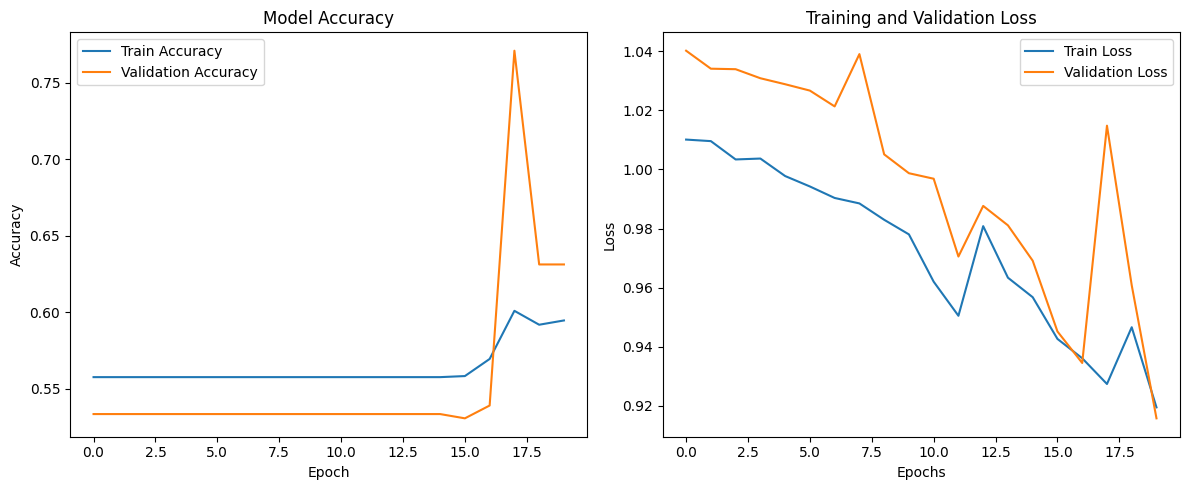

In [26]:
plot_history(feature_fc_history)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
      Dataset      Loss  Accuracy  Precision    Recall  F1-Score       AUC  \
0    Training  0.899452  0.620545   0.598304  0.972431  0.740811  0.574683   
1  Validation  0.915808  0.631285   0.594249  0.973822  0.738095  0.606671   
2        Test  0.975607  0.539216   0.526132  0.967949  0.681716  0.530641   

        mAP       IoU  
0  0.871989  0.527274  
1  0.883627  0.495512  
2  0.833888  0.493160  
Best IoU: 0.5273


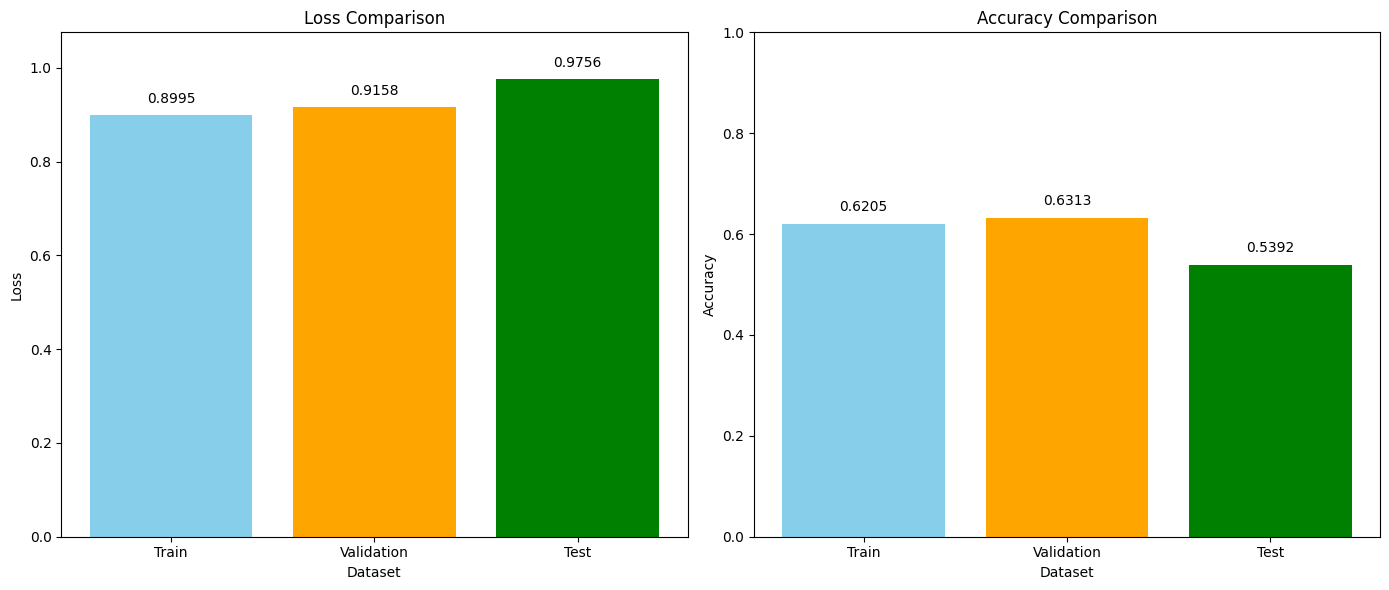

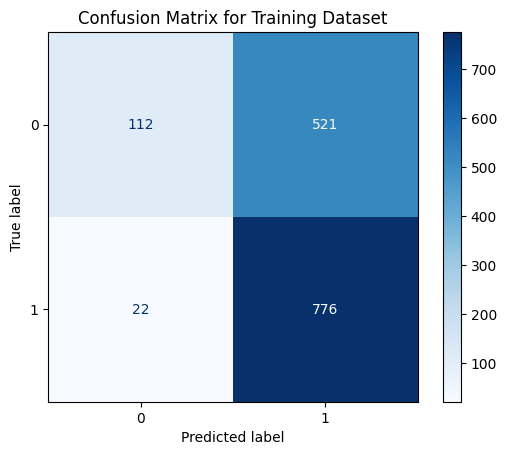

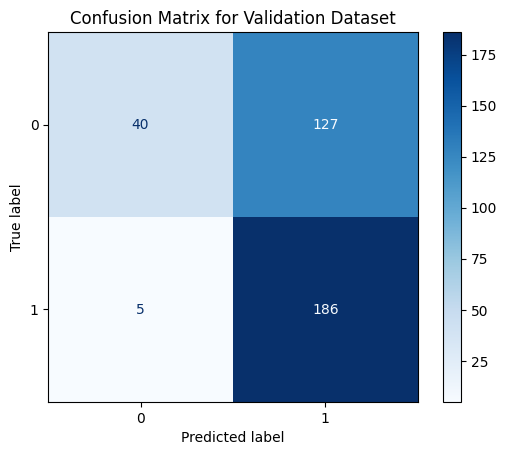

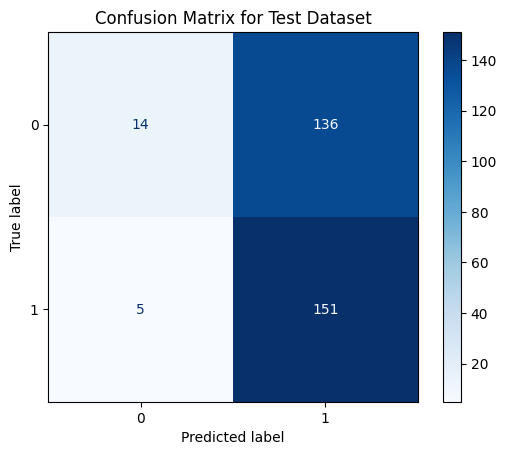

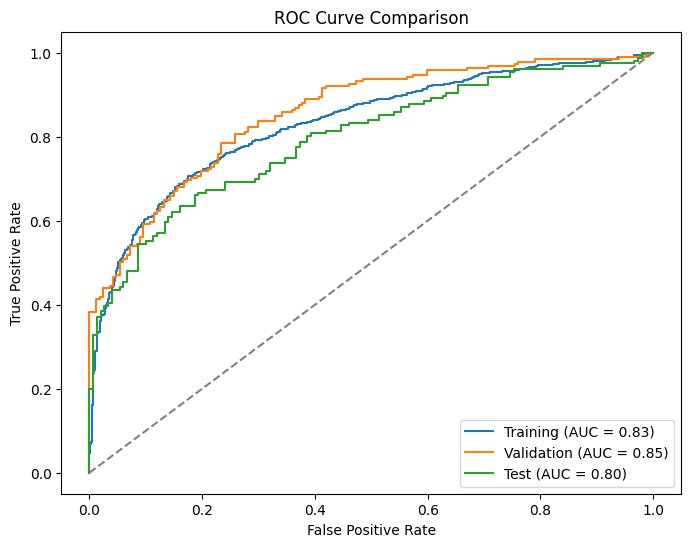

In [27]:
evaluate_and_plot(fc_classifier, X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)